## Safe Driver Prediction

### impot libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
#Remove redundant calls
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:#Required for sklearn wrapper
        p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

def feature_importances(rfc, features):
    x, y = (list(x) for x in zip(*sorted(zip(rfc.feature_importances_, features), 
                                                            reverse = False)))
    trace2 = go.Bar(
                    x=x ,
                    y=y,
                    marker=dict(
                                color=x,
                                colorscale = 'Viridis',
                                reversescale = True
                                ),
                    name='Gradient Boosting Classifer Feature importance',
                    orientation='h',
                    )

    layout = dict(
                  title='Barplot of Feature importances',
                  width = 900, height = 2000,
                  yaxis=dict(
                  showgrid=False,
                  showline=False,
                  showticklabels=True,
                  ))

    fig1 = go.Figure(data=[trace2])
    fig1['layout'].update(layout)
    py.iplot(fig1, filename='plots')
    
def feature_scatter(clf, features):
    trace = go.Scatter(
                       y = clf.feature_importances_,
                       x = features,
                       mode='markers',
                       marker=dict(
                                   sizemode = 'diameter',
                                   sizeref = 1,
                                   size = 13,
                                   color = rfc_draw.feature_importances_,
                                   colorscale='Portland',
                                   showscale=True
                                   ),
                       text = features
                       )
    data_rfc = [trace]

    layout= go.Layout(
                      autosize= True,
                      title= 'Gradient Boosting Machine Feature Importance',
                      hovermode= 'closest',
                      xaxis= dict(
                                  ticklen= 5,
                                  showgrid=False,
                                  zeroline=False,
                                  showline=False
                                  ),
                      yaxis=dict(
                                 title= 'Feature Importance',
                                 showgrid=False,
                                 zeroline=False,
                                 ticklen= 5,
                                 gridwidth= 2
                                 ),
                      showlegend= False
                      )
    fig = go.Figure(data=data_rfc, layout=layout)
    py.iplot(fig,filename='scatter2010')

In [3]:
import sklearn.metrics as metrics

gini_sklearn = metrics.make_scorer(gini_normalizedc, True, True)

### read dataset

In [4]:
data = pd.read_csv('train.csv')
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
data.replace(-1, np.nan, axis = 1, inplace = True)
data.info()

/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3786: UserWarning:

the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64

### Target values

The percentage of claimed insurers:3.64 %


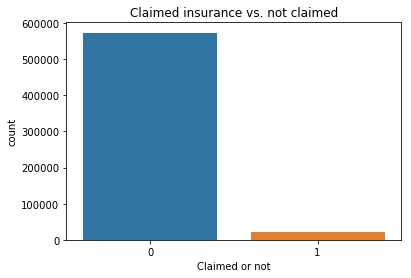

In [6]:
_ = sns.countplot(data.target)
_ = plt.title('Claimed insurance vs. not claimed')
_ = plt.xlabel('Claimed or not')
claimed_per = data.target.value_counts()[1]/len(data.target)
print("The percentage of claimed insurers:{:0.2f} %".format(np.round(claimed_per*100,2)))

Before checking outliers, we first check the target values of the data. From above results, it's obvious that the problem is to detect anomalies(to detect the 0.03645 users). Therefore, the concept of "outliers" may not be meaningful for this project.

### Categorical data

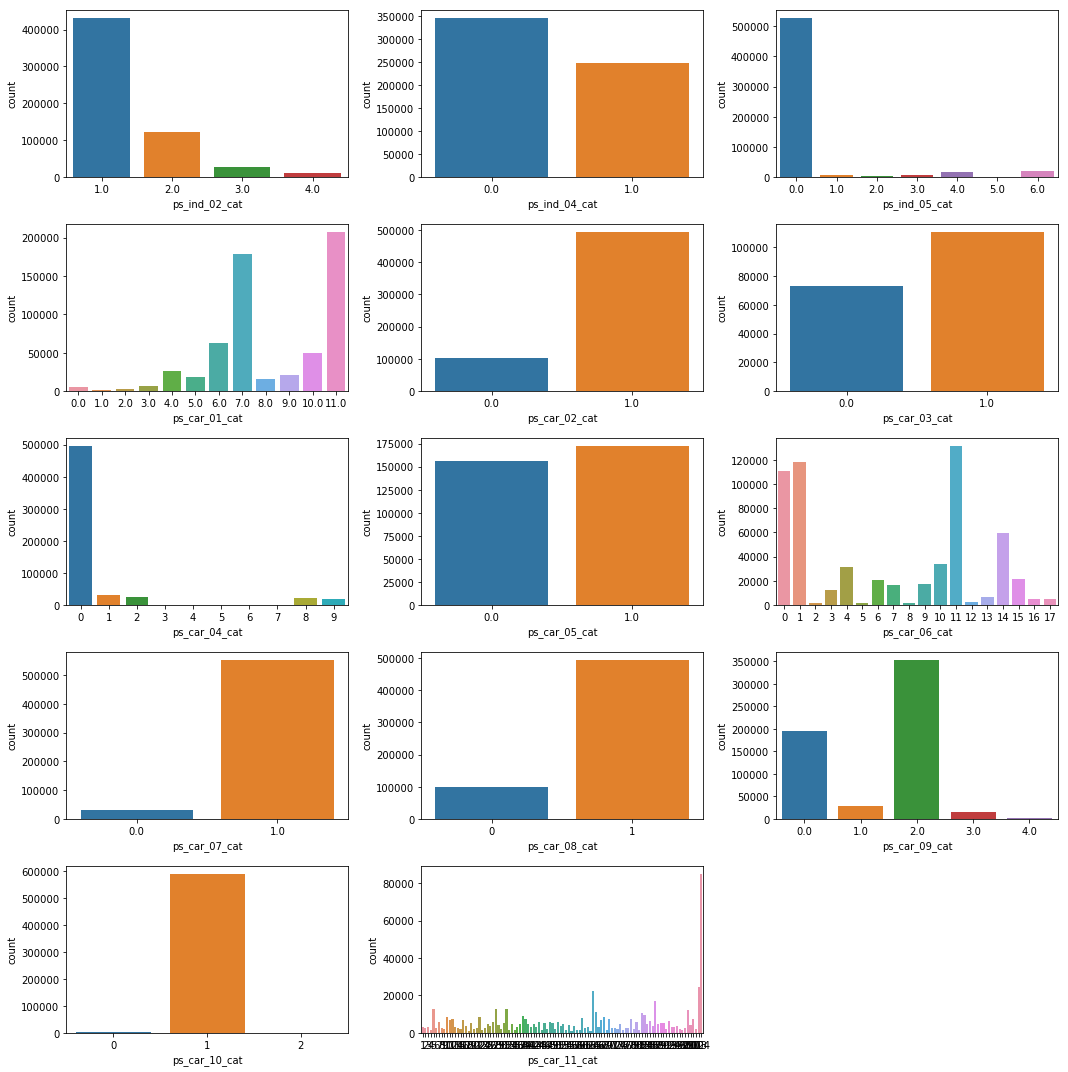

In [7]:
cate_data = data[[x for x in data.columns if"_cat" in x]]
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(15, 15))
i = 0
for i in range(len(cate_data.columns)):
    if i <=2:
        sns.countplot(cate_data.iloc[:,i],ax=axes[0][i])
    elif i <= 5:
        sns.countplot(cate_data.iloc[:,i],ax=axes[1][i-3])
    elif i <= 8:
        sns.countplot(cate_data.iloc[:,i],ax=axes[2][i-6])
    elif i <= 11:
        sns.countplot(cate_data.iloc[:,i],ax=axes[3][i-9])
    else:
        sns.countplot(cate_data.iloc[:,i],ax=axes[4][i-12])
plt.tight_layout()
fig.delaxes(axes[4,2])

In [8]:
cate_data.ps_car_10_cat.value_counts()

1    590179
0      4857
2       176
Name: ps_car_10_cat, dtype: int64

In [9]:
data_new = data.rename(columns={'ps_car_08_cat':'ps_car_08_cat_bin'})

### Split data
Since we have 59 columns which makes visualization sort of difficult, it is better to split the data into categorical features and non categorical features.

In [10]:
data_cat = data.select_dtypes(include=['int64'])
data_non_cat = data.select_dtypes(include=['float64'])

### Non-Categorical features visualization

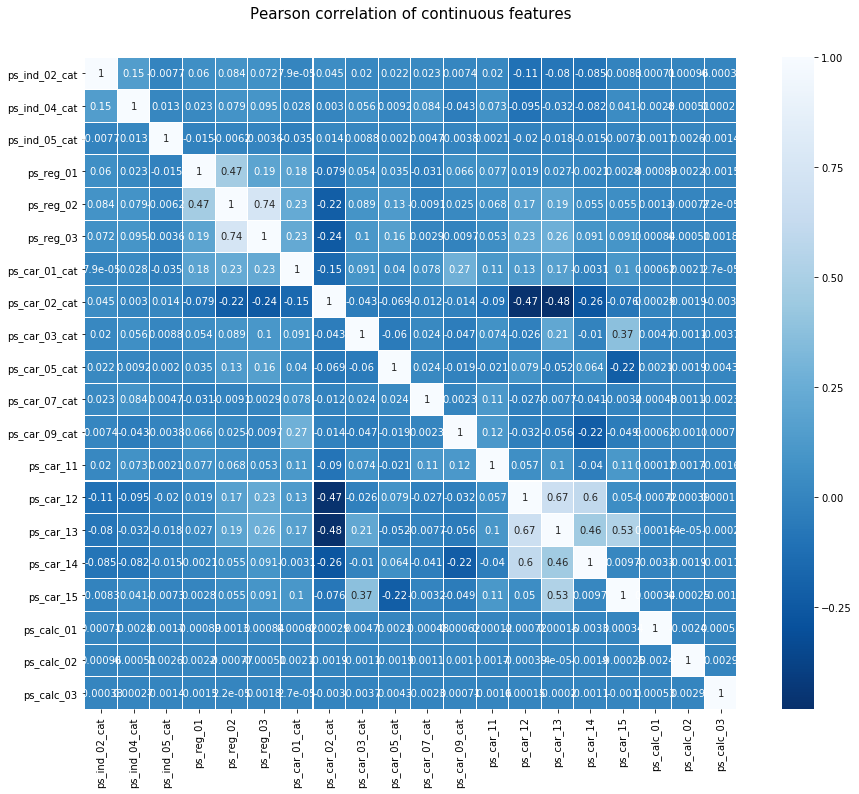

In [11]:
colormap = plt.cm.Blues_r
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(data_non_cat.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [12]:
data_vis = [
    go.Heatmap(
        z= data_non_cat.corr().values,
        x= data_non_cat.columns.values,
        y= data_non_cat.columns.values,
        colorscale='Viridis',
        reversescale = False,
        text = True,
        opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data_vis, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

In [13]:
bin_col = [col for col in data_new.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((data_new[col]==0).sum())
    one_list.append((data_new[col]==1).sum())


In [14]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data_bi = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data_bi, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [15]:
from sklearn.ensemble import RandomForestClassifier

rfc_draw = RandomForestClassifier()
rfc_draw.fit(data.drop(['id','target'],axis=1).fillna(-1), data.target)
features = data.drop(['id', 'target'],axis=1).columns.values

In [16]:
feature_scatter(rfc_draw, features)

In [17]:
feature_importances(rfc_draw, features)

### Feature Engineering

In [18]:
cla_data = data.drop(['ps_car_10_cat', 'ps_car_03_cat','ps_car_05_cat','ps_ind_10_bin',
                      'ps_ind_11_bin', 'ps_ind_12_bin','ps_ind_13_bin','ps_ind_14',
                      'id','target'], axis=1)

In [19]:
cla_data['ps_calc_06_sqr'] = cla_data.ps_calc_06**2
cla_data['ps_calc_02_sqr'] = cla_data.ps_calc_02**2
cla_data['ps_calc_03_sqr'] = cla_data.ps_calc_03**2

In [20]:
from sklearn.preprocessing import Imputer
imp_cat = Imputer(strategy='most_frequent')
imp_con = Imputer(strategy='mean')
col_cat = cla_data.select_dtypes(include=['int64']).columns
col_con = cla_data.select_dtypes(include=['float64']).columns
cats = imp_cat.fit_transform(cla_data.loc[:,col_cat])
cons = imp_con.fit_transform(cla_data.loc[:,col_con])

In [21]:
cats_df = pd.DataFrame(cats)
cons_df = pd.DataFrame(cons)
cats_df.columns = col_cat
cons_df.columns = col_con
cla_filled = pd.merge(cats_df, cons_df, left_index=True, right_index=True)

In [22]:
dfs = []
drop_cols = []
for col in cats_df.columns:
    if cla_filled[col].nunique() >= 3:
        #print(selected_train[col].nunique())
        drop_cols.append(col)
        col_df = pd.get_dummies(cla_filled[col])
        col_df = col_df.add_prefix(col)
        dfs.append(col_df)

In [23]:
merged_dummies = pd.DataFrame(np.ones(len(cla_filled)))
for df in dfs:
    merged_dummies = pd.merge(merged_dummies, df, left_index=True, right_index=True)

In [24]:
new_train = cla_filled.drop(drop_cols, axis=1)
new_train = pd.merge(merged_dummies, new_train, left_index=True, right_index=True)
new_train = new_train.drop(0, axis=1)

In [25]:
emp_cols = np.array(np.zeros([new_train.shape[0],6]))
empties = pd.DataFrame(data=emp_cols,
                       columns=['ps_calc_081.0','ps_calc_1120.0',
                                'ps_calc_1211.0','ps_calc_1314.0',
                                'ps_calc_1315.0','ps_calc_1428.0'])
new_train = pd.merge(new_train, empties, left_index=True, right_index=True)
new_train = new_train.sort_index(axis=1)

In [26]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Columns: 365 entries, ps_calc_01 to ps_reg_03
dtypes: float64(40), uint8(325)
memory usage: 366.1 MB


In [27]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()
norm.fit(new_train)
train_norm = norm.transform(new_train)

### RFC with selected features and cross validation

In [28]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced',
                     classes=np.unique(data.target), 
                     y=data.target)
class_weight = {0:weights[0], 1:weights[1]}

In [501]:
#Regular Cross Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

rfc = RandomForestClassifier(n_estimators=100, 
                             max_features='sqrt',
                             min_samples_leaf=60,
                             max_depth=None,
                             min_samples_split=2,
                             class_weight=class_weight,
                             n_jobs=-1,
                             #oob_score=True,
                             random_state=39)
#Stratified validation startegy
cv_1 = StratifiedKFold(n_splits=5, random_state=39).split(#selected_train,
                                                          #new_train,
                                                          train_norm,
                                                          data.target)

#Check cross validation scores
cross_val_score(rfc, 
                #selected_train, 
                #new_train,
                train_norm,
                data.target, 
                cv=cv_1, 
                scoring=gini_sklearn, 
                verbose=2)

[CV]  ................................................................
[CV] ................................................. , total= 2.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] ................................................. , total= 2.4min
[CV]  ................................................................
[CV] ................................................. , total= 2.4min
[CV]  ................................................................
[CV] ................................................. , total= 2.4min
[CV]  ................................................................
[CV] ................................................. , total= 2.3min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.1min finished


array([ 0.24089828,  0.2420711 ,  0.2477142 ,  0.25049856,  0.24559304])

In [62]:
rfc = RandomForestClassifier(n_estimators=300, 
                             max_features='sqrt',
                             min_samples_leaf=60,
                             max_depth=None,
                             min_samples_split=2,
                             class_weight=class_weight,
                             n_jobs=-1,
                             oob_score=True,
                             verbose=1,
                             random_state=39)

rfc.fit(b, data.target)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.3min finished


RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.51891309427079879, 1: 13.718355305614455},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=True, random_state=39,
            verbose=1, warm_start=False)

### XGBoost

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_norm, 
                                                  data.target, 
                                                  test_size=0.1,
                                                  random_state=39)

In [172]:
from xgboost import XGBClassifier
xgb=XGBClassifier(n_estimators=370,
                  max_depth=4,
                  objective="binary:logistic",      
                  learning_rate=0.05, 
                  subsample=0.8,
                  min_child_weight=0.77,
                  #max_delta_step=5,
                  colsample_bytree=0.8,
                  scale_pos_weight=1.6,
                  gamma=10,
                  reg_alpha=8,
                  reg_lambda=1.3,
                  seed=39,
                  n_jobs=-1)

In [173]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv_2 = StratifiedKFold(n_splits=5, random_state=39).split(cla_data,data.target)

#Check cross validation scores
cross_val_score(xgb, 
                cla_data,
                data.target, 
                cv=cv_2, 
                scoring=gini_sklearn, 
                verbose=2)

[CV]  ................................................................
[CV] ................................................. , total= 7.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min remaining:    0.0s


[CV] ................................................. , total= 6.4min
[CV]  ................................................................
[CV] ................................................. , total= 5.9min
[CV]  ................................................................
[CV] ................................................. , total= 6.8min
[CV]  ................................................................
[CV] ................................................. , total= 6.8min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 33.2min finished


array([ 0.280531  ,  0.28079828,  0.28125306,  0.28768744,  0.27125685])

In [167]:
xgb.fit(cla_data,data.target,eval_metric=gini_sklearn,verbose=2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=10, learning_rate=0.07,
       max_delta_step=0, max_depth=5, min_child_weight=0.77, missing=None,
       n_estimators=370, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=8,
       reg_lambda=1.3, scale_pos_weight=1.6, seed=39, silent=True,
       subsample=0.8)

### Test Part

In [30]:
test_data = pd.read_csv('test.csv')

In [31]:
test_data = test_data.replace(-1, np.nan)

In [32]:
test_final = (test_data.drop(['ps_car_10_cat', 'ps_car_03_cat','ps_car_05_cat','ps_ind_10_bin',
                      'ps_ind_11_bin', 'ps_ind_12_bin','ps_ind_13_bin','ps_ind_14','id'], axis=1))

In [33]:
test_final['ps_calc_06_sqr'] = test_final.ps_calc_06**2
test_final['ps_calc_02_sqr'] = test_final.ps_calc_02**2
test_final['ps_calc_03_sqr'] = test_final.ps_calc_03**2

cats_test = pd.DataFrame(imp_cat.transform(test_final.loc[:, col_cat]))
cons_test = pd.DataFrame(imp_con.transform(test_final.loc[:, col_con]))
cats_test.columns = col_cat
cons_test.columns = col_con
test_filled = pd.merge(cats_test, cons_test, left_index=True, right_index=True)

dfs = []
drop_cols = []
for col in cats_test.columns:
    if test_filled[col].nunique() >= 3:
        #print(selected_train[col].nunique())
        drop_cols.append(col)
        col_df = pd.get_dummies(test_filled[col])
        col_df = col_df.add_prefix(col)
        dfs.append(col_df)
        
test_dummies = pd.DataFrame(np.ones(len(test_filled)))
for df in dfs:
    test_dummies = pd.merge(test_dummies, df, left_index=True, right_index=True)
    
new_test = test_filled.drop(drop_cols, axis=1)
new_test = pd.merge(test_dummies, new_test, left_index=True, right_index=True)
new_test = new_test.drop(0, axis=1)

emp_test = np.array(np.zeros([new_test.shape[0],3]))
empties_test = pd.DataFrame(data=emp_test,
                       columns=['ps_calc_060.0','ps_calc_1210.0',
                                'ps_calc_06_sqr0.0'])
new_test = pd.merge(new_test, empties_test, left_index=True, right_index=True)
new_test = new_test.sort_index(axis=1)
test_norm = norm.transform(new_test)

In [168]:
proba = xgb.predict_proba(test_final)[:,1]

In [169]:
proba

array([ 0.04164963,  0.04175508,  0.04047527, ...,  0.06109792,
        0.03720558,  0.05887993], dtype=float32)

In [170]:
pro_df = pd.DataFrame(proba)
submit = pd.merge(test_data[['id']], pro_df, left_index=True, right_index=True)

In [171]:
submit.rename(columns={0:'target'}, inplace=True)
submit.to_csv('submit.csv', index=False)